In [ ]:
import sys
sys.path.append("../")

In [ ]:
from utils.common_train_utils import *
from utils.draw_candle_image import *
from functools import partial
from model_code import *
from ta import add_all_ta_features
from ta.utils import dropna
import json
import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import shutil
import ta
import ta.momentum
import ta.trend
import tempfile
import tensorflow as tf
import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

In [2]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

In [3]:
print(logdir)

C:\Users\ADMIN\AppData\Local\Temp\tmpnemvmpeb\tensorboard_logs


In [ ]:
dataset_folder = "../dataset/fpt_dataset_10_4_3_2014_2024_test_"

In [5]:
config = read_config(dataset_folder)
candle_type_and_directory_save: dict = config["candle_type_and_directory_save"]
previous_days = config["previous_days"]
next_days = config["next_days"]
days_result = config["days_result"]

In [6]:
dataset_train = load_dataset_train(dataset_folder, candle_type_and_directory_save)
total_data_train = len(dataset_train)
batch_size = 100

folder: bullish_engulfing, 		 total: 85 images
folder: bearish_engulfing, 		 total: 93 images
folder: star_doji, 		 total: 15 images
folder: dragonfly_doji, 		 total: 19 images
folder: gravestone_doji, 		 total: 23 images
folder: morning_star, 		 total: 66 images
folder: evening_star, 		 total: 73 images
folder: hammer, 		 total: 55 images
folder: inverted_hammer, 		 total: 87 images
folder: harami_down, 		 total: 83 images
folder: harami_up, 		 total: 124 images
folder: tweezer_top, 		 total: 48 images
folder: tweezer_bottom, 		 total: 48 images
folder: marubozu, 		 total: 139 images
folder: spin, 		 total: 75 images
folder: next_3_day_up, 		 total: 176 images
folder: next_3_day_down, 		 total: 151 images


In [7]:
total_data_train

1360

In [8]:
for images_train, labels_train in dataset_train.take(5):
    print(images_train.shape)
    print(labels_train.shape)

(287, 287, 3)
(18, 4)
(287, 287, 3)
(18, 4)
(287, 287, 3)
(18, 4)
(287, 287, 3)
(18, 4)
(287, 287, 3)
(18, 4)


In [9]:
image_shape = tuple(images_train.shape)

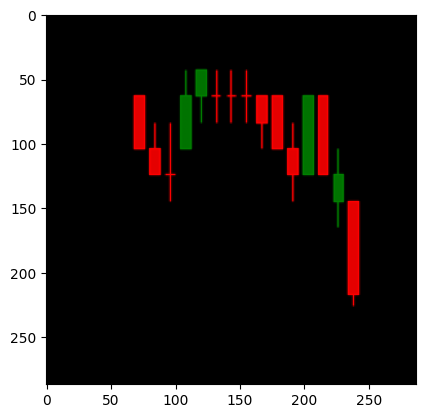

In [10]:
plt.imshow(images_train)

In [11]:
dataset_train = dataset_train.shuffle(300)

In [12]:
train_ratio = 0.8  # 80% dữ liệu để train
train_size = int(train_ratio * len(dataset_train))

In [13]:
dataset_test = dataset_train.skip(train_size)
dataset_train_take = dataset_train.take(train_size)

In [14]:
(len(dataset_train_take), len(dataset_test))

(1088, 272)

In [15]:
dataset_train_1 = dataset_train_take.batch(batch_size)
dataset_test_1 = dataset_test.batch(batch_size)

In [ ]:
transform_function = partial(get_open_close_prices_percent_of_last_days_result, days_result)
dataset_train_2 = dataset_train_1.map(transform_function)
dataset_test_2 = dataset_test_1.map(transform_function)

In [17]:
for x_dataset_train_2, ydataset_train_2 in dataset_train_2.take(1):
    pass
for x_dataset_test_2, ydataset_test_2 in dataset_test_2.take(1):
    pass

In [18]:
(len(dataset_train_2), len(dataset_test_2))

(11, 3)

In [19]:
dataset_train_2

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3, 2), dtype=tf.float64, name=None))>

In [20]:
dataset_test_2

<_MapDataset element_spec=(TensorSpec(shape=(None, 287, 287, 3), dtype=tf.float64, name=None), TensorSpec(shape=(None, 3, 2), dtype=tf.float64, name=None))>

In [21]:
model, model_name = model_5(image_shape, days_result)

In [22]:
model_name

'model_5'

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 286, 286, 8)    │           104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 143, 143, 8)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 141, 141, 8)    │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 70, 70, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 39200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │     1,254,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector (RepeatVector)    │ (None, 3, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 3, 64)          │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 3, 2)           │           130 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,281,138 (4.89 MB)

 Trainable params: 1,281,138 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

In [24]:
STEPS_PER_EPOCH = total_data_train // batch_size + 1
name_sub_folder_save_metrics = f"{model_name}_{dataset_folder}"
name_folder_save_metrics = f"sizes/{model_name}_{dataset_folder}"
max_epochs = 200

In [25]:
STEPS_PER_EPOCH

14

In [26]:
lr_schedule = keras.optimizers.schedules.InverseTimeDecay(
    0.001,
    decay_steps=STEPS_PER_EPOCH*100,
    decay_rate=1,
    staircase=False
)


def get_optimizer():
    return keras.optimizers.Adam(lr_schedule)


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        keras.callbacks.EarlyStopping(monitor='val_mean_absolute_error', patience=20),
        keras.callbacks.TensorBoard(logdir/name)
    ]


In [27]:
model.compile(
    loss=keras.losses.MeanSquaredError(),
    optimizer=get_optimizer(),
    metrics=[
        keras.metrics.MeanAbsoluteError(name="mean_absolute_error"),
    ],
)

In [ ]:
history = model.fit(
    dataset_train_2, 
    validation_data=dataset_test_2,
    epochs=max_epochs, 
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=get_callbacks(name_folder_save_metrics)
)

In [ ]:
def save_dataset(prefix, dataset_test, model_name):
    prefix_of_folder = prefix
    path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        prefix_of_folder = prefix_of_folder + "_1"
        path_save = f"{dataset_folder}/{prefix_of_folder}_of_{model_name}"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    tf.data.Dataset.save(dataset_test, path_save)

In [ ]:
def save_model(model: keras.Sequential, model_name):
    path_save = f"{dataset_folder}/{model_name}.keras"
    while os.path.exists(path_save):
        print(f"-- {path_save} already exists")
        model_name = model_name + "_1"
        path_save = f"{dataset_folder}/{model_name}.keras"
        print(f"-- Change to {path_save}")
    
    print(f"Save to {path_save}")
    model.save(path_save)

In [ ]:
save_model(model, model_name)
save_dataset("dataset_test", dataset_test_1, model_name)
save_dataset("dataset_train", dataset_train_1, model_name)

-- ./fpt_dataset_10_4_3_2014_2024_test_/model_5.keras already exists
-- Change to ./fpt_dataset_10_4_3_2014_2024_test_/model_5_1.keras
Save to ./fpt_dataset_10_4_3_2014_2024_test_/model_5_1.keras
Save to ./fpt_dataset_10_4_3_2014_2024_test_/dataset_test_of_model_5


In [ ]:
size_histories = {}

In [ ]:
size_histories[name_sub_folder_save_metrics] = history 

(0.0, 1.0)

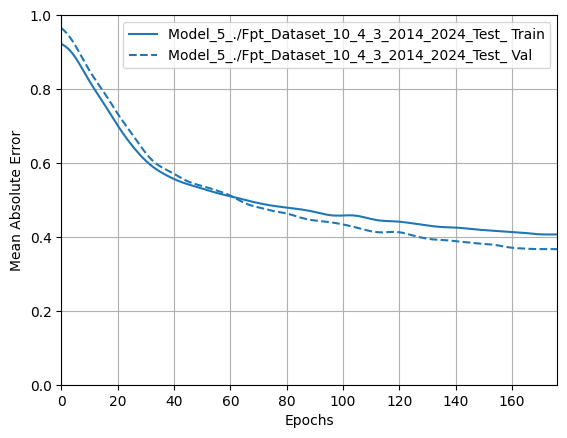

In [ ]:
plotter = tfdocs.plots.HistoryPlotter(metric='mean_absolute_error', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0,1])